# Prototype 02 
## Experiment 02
## --- Setup ---

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [3]:
# Standard Dependencies
import os
import sys
import torch
import numpy as np
import torch.nn as nn
from time import time
from tabulate import tabulate
import matplotlib.pyplot as plt

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Global Dependencies
from src.autoencoder import AutoEncoder, RMSELoss
from src.custom_types import Behavior, Execution, Evaluation, MTDTechnique, actions, mitigated_by
from src.data_provider import DataProvider
from src.experiment import Experiment
from src.functions import calculate_balance_metrics, split_training_data, plot_mid_sweep_test_accuracies, plot_wcs_sweep_test_accuracies
from src.functions import split_training_data, split_data, calculate_balance_metrics
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

In [5]:
from prototypes.prototype_02.environment import Environment
from prototypes.prototype_02.deep_q_network import DeepQNetwork
from prototypes.prototype_02.agent import Agent
from prototypes.prototype_02.client import Client
from prototypes.prototype_02.server import Server

In [6]:
rl_training_data, test_data, _ = DataProvider.get_scaled_train_test_split_one(scaling_minmax=True, scale_normal_only=True)
normal_data = rl_training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

rl_training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

rl_training_data_strides = split_training_data(rl_training_data, 10)

In [7]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, rl_training_data, n_hidden_1=64, n_hidden_2=16, activation_function=nn.GELU())
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=50, batch_size=64, verbose=False)

In [8]:
autoencoder.evaluate(n_std=5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 96.35\%    & \notCalculated & \notCalculated & \notCalculated &        4187 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        5318 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2589 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3847 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4129 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2083 \\
 CNC\_OPT1                & 99.97\%    & \notCalculated & \notCalculated & \notCalculated &        3034 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2131 \\

## --- Source ---

In [9]:
training_data_strides = split_training_data(rl_training_data, 10)
rl_test_data = test_data

In [10]:
def get_mid_sweep_sampling_probabilities(current_step, n_steps):
    lower_sampling_threshold = 0.0001
    unit_sampling_probability = 1/7
    
    fraction = (unit_sampling_probability - lower_sampling_threshold)/n_steps
    offset = current_step * fraction
    
    minor_sampling_probability = unit_sampling_probability - offset
    major_sampling_probability = unit_sampling_probability + 6 * offset

    sampling_probabilities = {
        Behavior.RANSOMWARE_POC: major_sampling_probability,
        Behavior.ROOTKIT_BDVL: minor_sampling_probability,
        Behavior.ROOTKIT_BEURK: minor_sampling_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: minor_sampling_probability ,
        Behavior.CNC_THETICK: minor_sampling_probability,
        Behavior.CNC_OPT1: minor_sampling_probability,
        Behavior.CNC_OPT2: minor_sampling_probability,
    }
    return sampling_probabilities

In [22]:
def run_mid_sweep_experiment(experiment_id, experiment_version, training_data_strides, n_steps):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    N_STATE_SAMPLES = 1
    
    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = len(training_data_strides)
    NR_ROUNDS = 30
    NR_EPISODES_PER_ROUND = 100
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 64
    N_HIDDEN_3 = 32
    N_FEATURES = training_data_strides[0][Behavior.NORMAL].shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01

    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    EPSILON_END = 0.01

    final_micro_accuracies = {}
    final_macro_accuracies = {}
    
    for current_step in range(n_steps+1):
        print(f"=== Running MID Sweep Split {current_step}/{n_steps} ===")
        sampling_probabilities = get_mid_sweep_sampling_probabilities(current_step, n_steps)
        MID, WCS = calculate_balance_metrics(sampling_probabilities, sampling_probabilities, NR_EPISODES_PER_CLIENT)
        assert round(WCS, 4) == 1, "WCS has to be 1"
        
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        server = Server(global_agent, rl_test_data, autoencoder, experiment_id, experiment_path)

        clients = []
        for i in range(NR_CLIENTS):
            entity_id = i + 1
            environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=sampling_probabilities, verbose=False)
            deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
            optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
            agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
            client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
            server.add_client(client)

        evaluations = [Evaluation.FINAL_PERFORMANCE_EVALUATION]
        experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1, verbose=False)
        micro_accuracy, macro_accuracy = server.final_training_accuracy()
        final_micro_accuracies[MID] = micro_accuracy
        final_macro_accuracies[MID] = macro_accuracy
    return experiment, final_micro_accuracies, final_macro_accuracies

In [23]:
e2v1, e2v1_final_micro_accuracies, e2v1_final_macro_accuracies = run_mid_sweep_experiment(2, 1, training_data_strides, 11)

=== Running MID Sweep Split 0/11 ===
Dataset Balance Metrics: MID=0.0 & WCS=1.0
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.68 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.56 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      96.65 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |     100    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORI

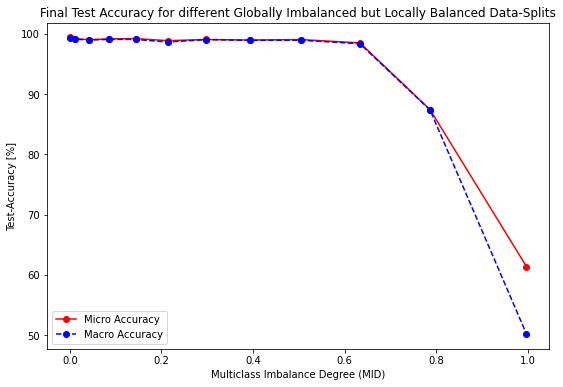

In [24]:
plot_mid_sweep_test_accuracies(e2v1_final_micro_accuracies, e2v1_final_macro_accuracies)

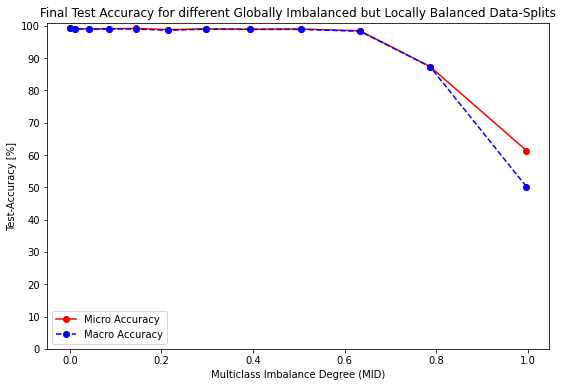

In [59]:
plot_mid_sweep_test_accuracies(e2v1_final_micro_accuracies, e2v1_final_macro_accuracies)

In [39]:
def get_wcs_sweep_sampling_probabilities(current_step, n_steps):
    baseline_probability  = 1/7
    lower_sampling_threshold = 0.0001

    fraction = (baseline_probability - lower_sampling_threshold)/n_steps
    baseline_deviation = current_step * fraction
    
    inc_probability = baseline_probability + baseline_deviation
    dec_probability = baseline_probability - baseline_deviation


    sampling_probabilities_1 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: inc_probability,
        Behavior.ROOTKIT_BDVL: inc_probability,
        Behavior.ROOTKIT_BEURK: inc_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: dec_probability,
        Behavior.CNC_OPT2: dec_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: dec_probability,
    }

    sampling_probabilities_2 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: dec_probability, 
        Behavior.ROOTKIT_BDVL: dec_probability,
        Behavior.ROOTKIT_BEURK: dec_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: inc_probability,
        Behavior.CNC_OPT2: inc_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: inc_probability,
    }
    
    return sampling_probabilities_1, sampling_probabilities_2

In [50]:
def run_wcs_sweep_experiment(experiment_id, experiment_version, training_data_strides, n_steps):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    N_STATE_SAMPLES = 1
    
    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = len(training_data_strides)
    NR_ROUNDS = 30
    NR_EPISODES_PER_ROUND = 100
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 64
    N_HIDDEN_3 = 32
    N_FEATURES = rl_training_data[Behavior.NORMAL].shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01

    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    EPSILON_END = 0.01

    final_micro_accuracies = {}
    final_macro_accuracies = {}
    
    for current_step in range(n_steps+1):
        print(f"=== Running MID Sweep Split {current_step}/{n_steps} ===")
        sampling_probabilities_01, sampling_probabilities_02 = get_wcs_sweep_sampling_probabilities(current_step, n_steps)
        MID, WCS = calculate_balance_metrics(sampling_probabilities_01, sampling_probabilities_02)
        assert round(MID, 4) == 0, f"MID has to be 0, but right now it is {MID}"
        
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        server = Server(global_agent, rl_test_data, autoencoder, experiment_id, experiment_path)

        clients = []
        for i in range(NR_CLIENTS):
            entity_id = i + 1
            if entity_id % 2 == 0:
                sampling_probabilities = sampling_probabilities_01
            else:
                sampling_probabilities = sampling_probabilities_02
            environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=sampling_probabilities, verbose=False)
            deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
            optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
            agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
            client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
            server.add_client(client)

        evaluations = [Evaluation.FINAL_PERFORMANCE_EVALUATION]
        experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1, verbose=False)
        micro_accuracy, macro_accuracy = server.final_training_accuracy()
        final_micro_accuracies[WCS] = micro_accuracy
        final_macro_accuracies[WCS] = macro_accuracy
    return experiment, final_micro_accuracies, final_macro_accuracies

In [51]:
e2v2, e2v2_final_micro_accuracies, e2v2_final_macro_accuracies = run_wcs_sweep_experiment(2, 2, training_data_strides, 11)

=== Running MID Sweep Split 0/11 ===
Dataset Balance Metrics: MID=0.0 & WCS=1.0
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.2  | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.47 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      96.92 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.93 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORI

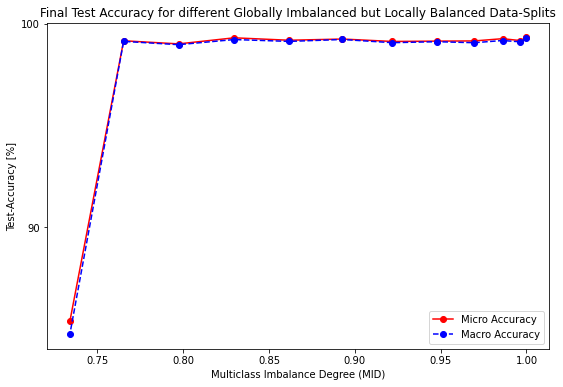

In [52]:
plot_wcs_sweep_test_accuracies(e2v2_final_micro_accuracies, e2v2_final_macro_accuracies)

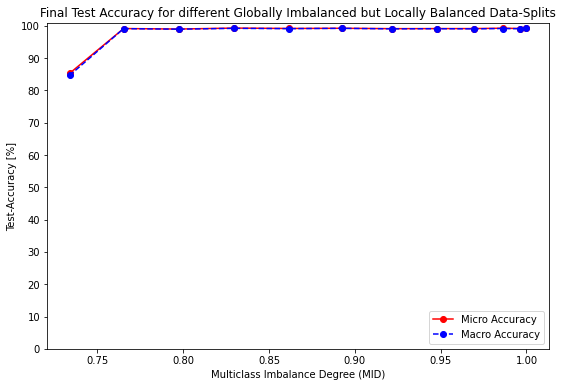

In [60]:
plot_wcs_sweep_test_accuracies(e2v2_final_micro_accuracies, e2v2_final_macro_accuracies)

In [53]:
from functools import reduce

def get_wcs_mid_sweep_sampling_probabilities(current_step, n_steps):
    unit_sampling_probability = 1/7
    minor_sampling_probability_01 = unit_sampling_probability - (current_step/n_steps) * unit_sampling_probability
    major_sampling_probability_01 = unit_sampling_probability + (current_step/n_steps) * 3/4 * unit_sampling_probability
    
    minor_sampling_probability_02 = unit_sampling_probability + (current_step/n_steps) * 4/3 * unit_sampling_probability
    major_sampling_probability_02 = unit_sampling_probability - (current_step/n_steps) * unit_sampling_probability
    
    sampling_probabilities_01 = {
        Behavior.ROOTKIT_BDVL: major_sampling_probability_01,
        Behavior.ROOTKIT_BEURK: minor_sampling_probability_01,
        Behavior.CNC_BACKDOOR_JAKORITAR: major_sampling_probability_01,
        Behavior.CNC_THETICK: minor_sampling_probability_01, 
        Behavior.CNC_OPT1: major_sampling_probability_01,
        Behavior.CNC_OPT2: minor_sampling_probability_01,
        Behavior.RANSOMWARE_POC: major_sampling_probability_01
    }
    sum_of_percentages = reduce(lambda x, y: x+y, sampling_probabilities_01.values())
    assert round(sum_of_percentages, 4) == 1, f"Make sure that all sampling probabilities 01 sum to 100%. Right now it is {sum_of_percentages*100} %"
    
    sampling_probabilities_02 = {
        Behavior.ROOTKIT_BDVL: major_sampling_probability_02,
        Behavior.ROOTKIT_BEURK: minor_sampling_probability_02,
        Behavior.CNC_BACKDOOR_JAKORITAR: major_sampling_probability_02,
        Behavior.CNC_THETICK: minor_sampling_probability_02, 
        Behavior.CNC_OPT1: major_sampling_probability_02,
        Behavior.CNC_OPT2: minor_sampling_probability_02,
        Behavior.RANSOMWARE_POC: major_sampling_probability_02
    }
    sum_of_percentages = reduce(lambda x, y: x+y, sampling_probabilities_02.values())
    assert round(sum_of_percentages, 4) == 1, f"Make sure that all sampling probabilities 02 sum to 100%. Right now it is {sum_of_percentages*100} %"
    
    return sampling_probabilities_01, sampling_probabilities_02

In [54]:
def run_wcs_mid_sweep_experiment(experiment_id, experiment_version, training_data_strides, n_steps):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    N_STATE_SAMPLES = 1
    
    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = len(training_data_strides)
    NR_ROUNDS = 30
    NR_EPISODES_PER_ROUND = 100
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 64
    N_HIDDEN_3 = 32
    N_FEATURES = rl_training_data[Behavior.NORMAL].shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01

    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    EPSILON_END = 0.01

    final_micro_accuracies = {}
    final_macro_accuracies = {}
    
    for current_step in range(n_steps+1):
        print(f"=== Running MID Sweep Split {current_step}/{n_steps} ===")
        sampling_probabilities_01, sampling_probabilities_02 = get_wcs_mid_sweep_sampling_probabilities(current_step, n_steps)
        MID, WCS = calculate_balance_metrics(sampling_probabilities_01, sampling_probabilities_02)
        
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        server = Server(global_agent, rl_test_data, autoencoder, experiment_id, experiment_path)

        clients = []
        for i in range(NR_CLIENTS):
            entity_id = i + 1
            if entity_id % 2 == 0:
                sampling_probabilities = sampling_probabilities_01
            else:
                sampling_probabilities = sampling_probabilities_02
            environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=sampling_probabilities, verbose=False)
            deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
            optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
            agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
            client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
            server.add_client(client)


        evaluations = [Evaluation.FINAL_PERFORMANCE_EVALUATION]
        experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1, verbose=False)
        micro_accuracy, macro_accuracy = server.final_training_accuracy()
        final_micro_accuracies[WCS] = micro_accuracy
        final_macro_accuracies[WCS] = macro_accuracy
    return experiment, final_micro_accuracies, final_macro_accuracies

In [55]:
e2v3, e2v3_final_micro_accuracies, e2v3_final_macro_accuracies = run_wcs_mid_sweep_experiment(2, 3, training_data_strides, 11)

=== Running MID Sweep Split 0/11 ===
Dataset Balance Metrics: MID=0.0 & WCS=1.0
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      98.98 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.2  | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      95.41 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.93 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORI

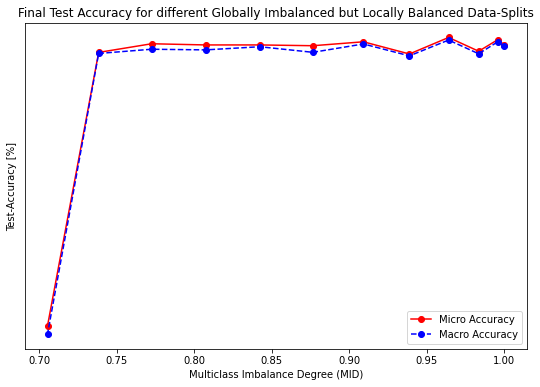

In [56]:
plot_wcs_sweep_test_accuracies(e2v3_final_micro_accuracies, e2v3_final_macro_accuracies)

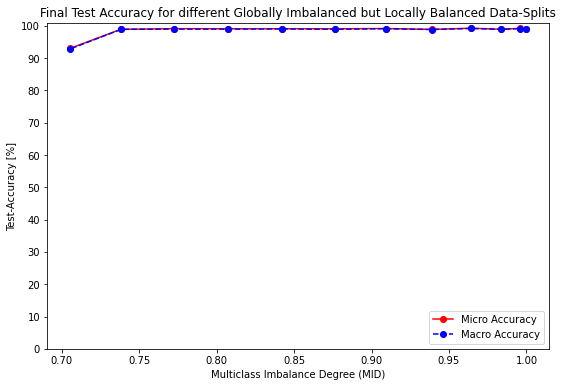

In [61]:
plot_wcs_sweep_test_accuracies(e2v3_final_micro_accuracies, e2v3_final_macro_accuracies)